In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import mplhep as hep
import pickle
import pandas as pd
import glob

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
ak.behavior.update(candidate.behavior)

def getLZDF(f,treename ="MuonSystem",nEvents=-1):
    events_raw = uproot.open(f)[treename]
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    if treename=="MuonSystem":
        return pack(events)
    else:
        return events
    
def pack(events):
    events.info=ak.zip({
        "runNum": events.runNum,
        "lumiNum": events.lumiNum,
        "evtNum": events.eventNum,
        }
    )
    events.cls=ak.zip({
        'eta':events.ca4CSCclusterEta,
        'phi':events.ca4CSCclusterPhi,
        'x':events.ca4CSCclusterX,        
        'y':events.ca4CSCclusterY,
        'z':events.ca4CSCclusterZ,                
        'size':events.ca4CSCclusterSize,
        'time':events.ca4CSCclusterTime,
        'timeSpread':events.ca4CSCclusterTimeSpread,            
        "nME11_12": events.ca4CSCclusterME11_12,
        'time':events.ca4CSCclusterTime,            
        "nStation10": events.ca4CSCclusterNstation10,
        "avgStation10": events.ca4CSCclusterAvgStation10,            
        }    
    )
    events.cls_dt=ak.zip({
        'eta': events.ca4DTclusterEta,
        'phi': events.ca4DTclusterPhi,
        'x':   events.ca4DTclusterX,        
        'y':   events.ca4DTclusterY,
        'z':   events.ca4DTclusterZ,                
        'size':events.ca4DTclusterSize,
        'time':events.ca4DTclusterTime,
        "nMB1": events.ca4DTclusterMB1,
        "nMB2": events.ca4DTclusterMB2,            
        "nStation10": events.ca4DTclusterNstation10,
        "avgStation10": events.ca4DTclusterAvgStation10,            
        }    
    )
    return events

def plotCls(d=[{"cls":"cls","label":"data"}],version="new",density=False):
    
    fig, axs = plt.subplots(6,2,figsize=(16,36))
#     hep.set_style(hep.style.CMS)
    plt.style.use(hep.style.CMS) 
    axs = axs.flatten()
    density = density
    h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))
    h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("eta", "eta", 40, -5, 5))    
    h3= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("phi", "phi", 40, -np.pi, np.pi))        
    h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("size", "size", 100, 0, 1000))        
    h5= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("time", 'ClusterTime[ns]',80, -80, 80))            
    if version=="DT":
        h6 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nMB1", 'nMB1',40, 0, 40))
        h12= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nMB2", "nMB2", 40, 0, 40))        
    else:
        h6 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nME11_12", 'nME11_12',40, 0, 40))        
        h12= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("timeSpread", "timeSpread[ns]", 80, 0, 100))
        
    h7 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("x", "x", 100, -1000, 1000))        
    h8 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("y", "y", 100, -1000, 1000))        
    h9 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("z", "z", 100, -1000, 1000))            
    h10= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Nstation10", "Nstation10", 8, 0, 8))    
    h11= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("AvgStation10", "AvgStation10", 40, 0, 8))    
    
    hall = [h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12]
    for sample in d:
        cls = sample['cls']
        label = sample['label']
        h1.fill(sample=label,nClusters=ak.num(cls))
        h2.fill(sample=label,eta = ak.flatten(cls.eta))
        h3.fill(sample=label,phi = ak.flatten(cls.phi)) 
        h4.fill(sample=label,size = ak.flatten(cls.size))
        h5.fill(sample=label,time = ak.flatten(cls.time)) 
        if version=="DT":
            h6.fill (sample=label,nMB1 = ak.flatten(cls.nMB1))        
            h12.fill(sample=label,nMB2 = ak.flatten(cls.nMB2))                
        elif version=="new":
            h6.fill (sample=label,nME11_12 = ak.flatten(cls.nME11_12))
            h12.fill(sample=label,timeSpread = ak.flatten(cls.timeSpread))                
        else:
            h6.fill(sample=label,nME11_12 = ak.flatten(cls.nME11+cls.nME12))        

        h7.fill( sample=label,x = ak.flatten(cls.x))    
        h8.fill( sample=label,y = ak.flatten(cls.y))    
        h9.fill( sample=label,z = ak.flatten(cls.z))        
        h10.fill(sample=label,Nstation10 = ak.flatten(cls.nStation10))            
        h11.fill(sample=label,AvgStation10 = ak.flatten(cls.avgStation10))                
    
    
    hist.plot1d(h1,density=density,ax=axs[0])
    hist.plot1d(h2,density=density,ax=axs[1])
    hist.plot1d(h3,density=density,ax=axs[2])
    hist.plot1d(h4,density=density,ax=axs[3])
    hist.plot1d(h5,density=density,ax=axs[4])
    hist.plot1d(h6,density=density,ax=axs[5])    
    hist.plot1d(h7,density=density,ax=axs[6])    
    hist.plot1d(h8,density=density,ax=axs[7])    
    hist.plot1d(h9,density=density,ax=axs[8])    
    hist.plot1d(h10,density=density,ax=axs[9])    
    hist.plot1d(h11,density=density,ax=axs[10])    
    hist.plot1d(h12,density=density,ax=axs[11])        
    
    if density:
        axs[5].set_yscale("log")
        axs[5].set_ylim(1e-4,None)
    axs[3].set_yscale("log")
    axs[3].set_ylim(1e-4,None)
        
    for ax in axs:
        hep.cms.label(ax=ax,data=True,label="Preliminary")        
#         ax.legend([label])
    plt.tight_layout()
    plt.show()
    

In [19]:
f = "/uscms/home/kkwok/lpclonglived/HLT/zerobias22/plots_run359694.root"

In [20]:

hmt = getLZDF(f,'simpleCSCshowerFilter/hmt')
cls = ak.zip(
    {k.replace("ca4CSCcluster",""):getattr(hmt,k) for k in hmt.fields if k.startswith("ca4CSCcluster")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )

muons = ak.zip(
    {k.replace("muon",""):getattr(hmt,k) for k in hmt.fields if k.startswith("muon")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )

lctHMT = ak.zip({k.replace("lctHMT_",""):getattr(hmt,k) for k in hmt.fields if k.startswith("lctHMT_")})
elctHMT = ak.zip({k.replace("elctHMT_",""):getattr(hmt,k) for k in hmt.fields if k.startswith("elctHMT_")})

hmt.uniqueStation = ak.max(hmt.cscRechitsChamber,axis=1)==ak.min(hmt.cscRechitsChamber,axis=1)
hmt.passL1_emul = ak.any(hmt.elctHMT_bits>1,axis=1)
cls.R = (cls.X**2+ cls.Y**2)**0.5
mu_veto = ~(ak.all( (hmt.muonPt>10)&(hmt.muonIsGlobal)&(hmt.muonIsMedium) ,axis=1) )

In [21]:
hmt

<Array [{passL1: 0, hasCluster: 0, ... ] type='2232091 * {"passL1": int32, "hasC...'>

In [43]:
elctHMT.fields

['chamber', 'sr', 'bits', 'BX', 'ComparatorNHits', 'WireNHits']

In [44]:
np.unique(ak.flatten(elctHMT.BX))

<Array [5, 6, 7, 8, 9, 10] type='6 * int32'>

In [40]:
np.unique(ak.flatten(elctHMT.chamber))

<Array [1, 2, 3, 4, 5, ... 32, 33, 34, 35, 36] type='36 * int32'>

In [39]:
np.unique(ak.flatten(elctHMT.sr))

<Array [0, 1, 2, 3, 4, ... 13, 14, 15, 16, 17] type='18 * int32'>

In [45]:
sr_map =[(8,9),(7,10),(6,11),(5,12),(4,13),(3,14),(2,15),(1,16),(0,17)]

In [47]:
sr_map[0][0]

8

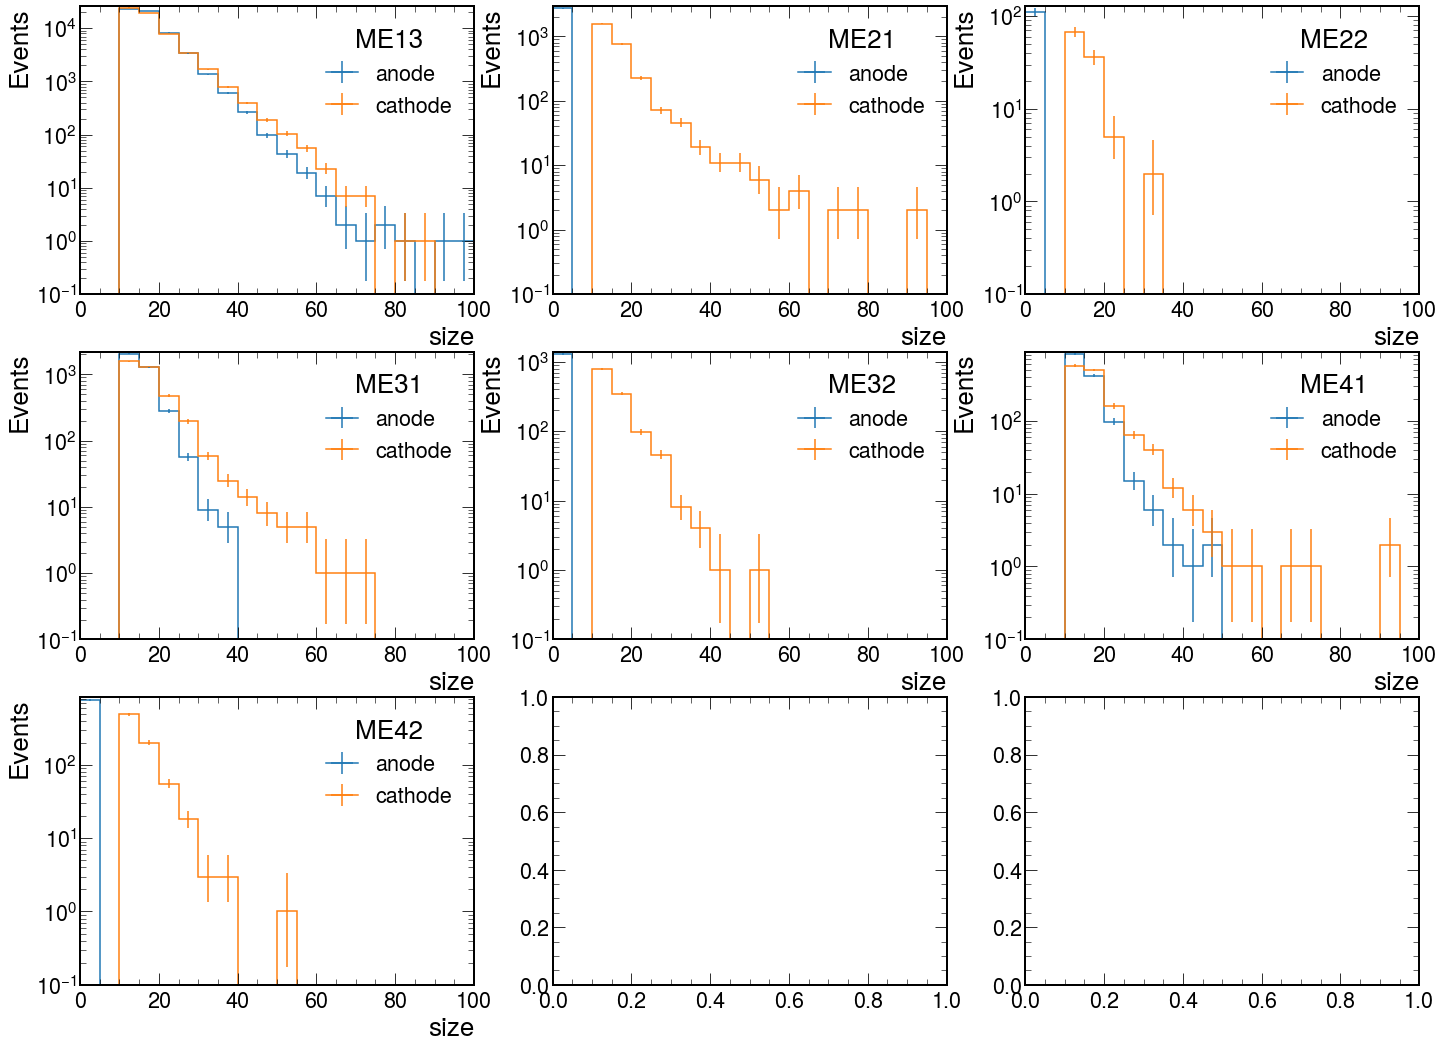

In [50]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(3,3, figsize=(24,18))
axs = axs.flatten()

labels  = ["ME11","ME12","ME13",'ME21','ME22','ME31','ME32',"ME41","ME42"]
sr_map =[(8,9),(7,10),(6,11),(5,12),(4,13),(3,14),(2,15),(1,16),(0,17)]

for i,label in enumerate(labels[2:]):
    h = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("size", "size", 20, 0, 200))
    #pick station-ring
    sel = ((elctHMT.sr==sr_map[i][0])|elctHMT.sr==sr_map[i][1])
    h.fill(sample="cathode",size=ak.flatten(elctHMT[sel].WireNHits))
    h.fill(sample="anode",size=ak.flatten(elctHMT[sel].ComparatorNHits))
    hist.plot1d(h,ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e-1,None)
    axs[i].legend(title=label)

(0.1, 18156.59866457335)

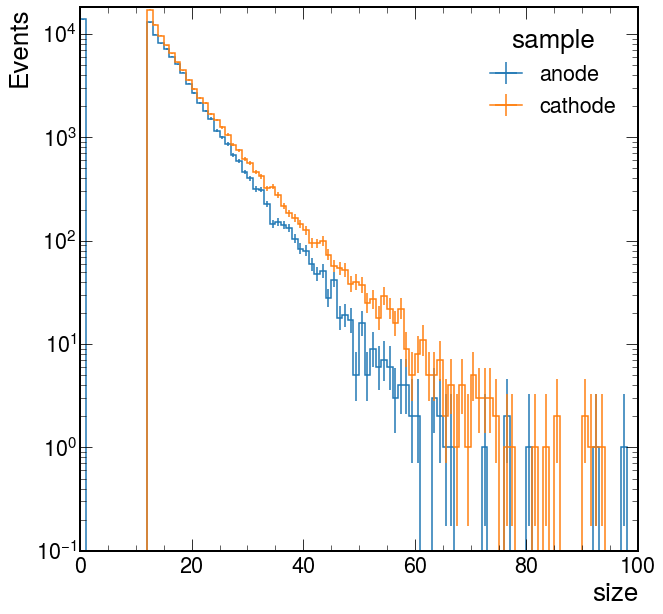

In [32]:
h = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("size", "size", 100, 0, 100))  
h.fill(sample="cathode",size=ak.flatten(elctHMT.WireNHits))
h.fill(sample="anode",size=ak.flatten(elctHMT.ComparatorNHits))
ax = hist.plot1d(h)
ax.set_yscale("log")
ax.set_ylim(1e-1,None)

In [8]:
hmt.fields

['passL1',
 'hasCluster',
 'nlctHMT',
 'runNum',
 'lumiNum',
 'eventNum',
 'eventCounter',
 'isHLT_HIZeroBias',
 'isHLT_HIMinimumBias',
 'isHLT_PPZeroBias',
 'lctHMT_chamber',
 'lctHMT_sr',
 'lctHMT_bits',
 'lctHMT_BX',
 'lctHMT_ComparatorNHits',
 'lctHMT_WireNHits',
 'nelctHMT',
 'elctHMT_chamber',
 'elctHMT_sr',
 'elctHMT_bits',
 'elctHMT_BX',
 'elctHMT_ComparatorNHits',
 'elctHMT_WireNHits',
 'ncscRechits',
 'ncscRechitsChambers',
 'cscRechitsPhi',
 'cscRechitsEta',
 'cscRechitsX',
 'cscRechitsY',
 'cscRechitsZ',
 'cscRechitsE',
 'cscRechitsTpeak',
 'cscRechitsTwire',
 'cscRechitsQuality',
 'cscRechitsChamber',
 'cscRechitsIChamber',
 'cscRechitsStation',
 'nMuons',
 'muonE',
 'muonPt',
 'muonEta',
 'muonPhi',
 'muonCharge',
 'muonIsLoose',
 'muonIsMedium',
 'muonIsGlobal',
 'nca4CSCcluster',
 'ca4CSCclusterSize',
 'ca4CSCclusterX',
 'ca4CSCclusterY',
 'ca4CSCclusterZ',
 'ca4CSCclusterEta',
 'ca4CSCclusterPhi',
 'ca4CSCclusterTpeak',
 'ca4CSCclusterWireTime',
 'ca4CSCclusterTime',
 

In [5]:
def HLTFilters(cls,thres=[]):
    L1cls = cls
    L1cls = L1cls[(L1cls.Time<12.5)&(L1cls.Time>-5)&(L1cls.ME11_12==0)]
#     L1cls = L1cls[(L1cls.Time<12.5)&(L1cls.Time>-5)]
#     L1cls = L1cls[(L1cls.ME11_12==0)]
    c1 = ak.any((abs(L1cls.Eta)<=1.9)&(L1cls.Nstation10>1) & (L1cls.Size>=thres[0]),axis=1)
    c2 = ak.any((abs(L1cls.Eta)<=1.9)&(L1cls.Nstation10<=1) &(L1cls.Size>=thres[1]),axis=1)
    c3 = ak.any((abs(L1cls.Eta)>1.9)&(L1cls.Nstation10>1) &  (L1cls.Size>=thres[2]),axis=1)
    c4 = ak.any((abs(L1cls.Eta)>1.9)&(L1cls.Nstation10<=1) & (L1cls.Size>=thres[3]),axis=1)
    mask = (c1|c2|c3|c4)
    return mask
HLTLoose  = HLTFilters(cls,[100,200,500,500])
HLTMedium = HLTFilters(cls,[100,300,500,800])
HLTTight  = HLTFilters(cls,[100,500,500,800])


def plotEff(numer,denom,ax,label=None):
    binning = np.array(
        [ 0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
       220., 240., 260., 280., 300., 500., 700.]
    )
    h= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("ClusterSize", "ClusterSize", binning))        
    h.fill(sample="numer",ClusterSize=numer)
    h.fill(sample="denom",ClusterSize=denom)

    hist.plotratio(num=h.integrate("sample",'numer'),
                   denom=h.integrate("sample",'denom'),
                    xerr=True,
                   error_opts={"linestyle":'none',"lw":2},
                   ax=ax,clear=False,
                  label=label)
    return ax

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encounter

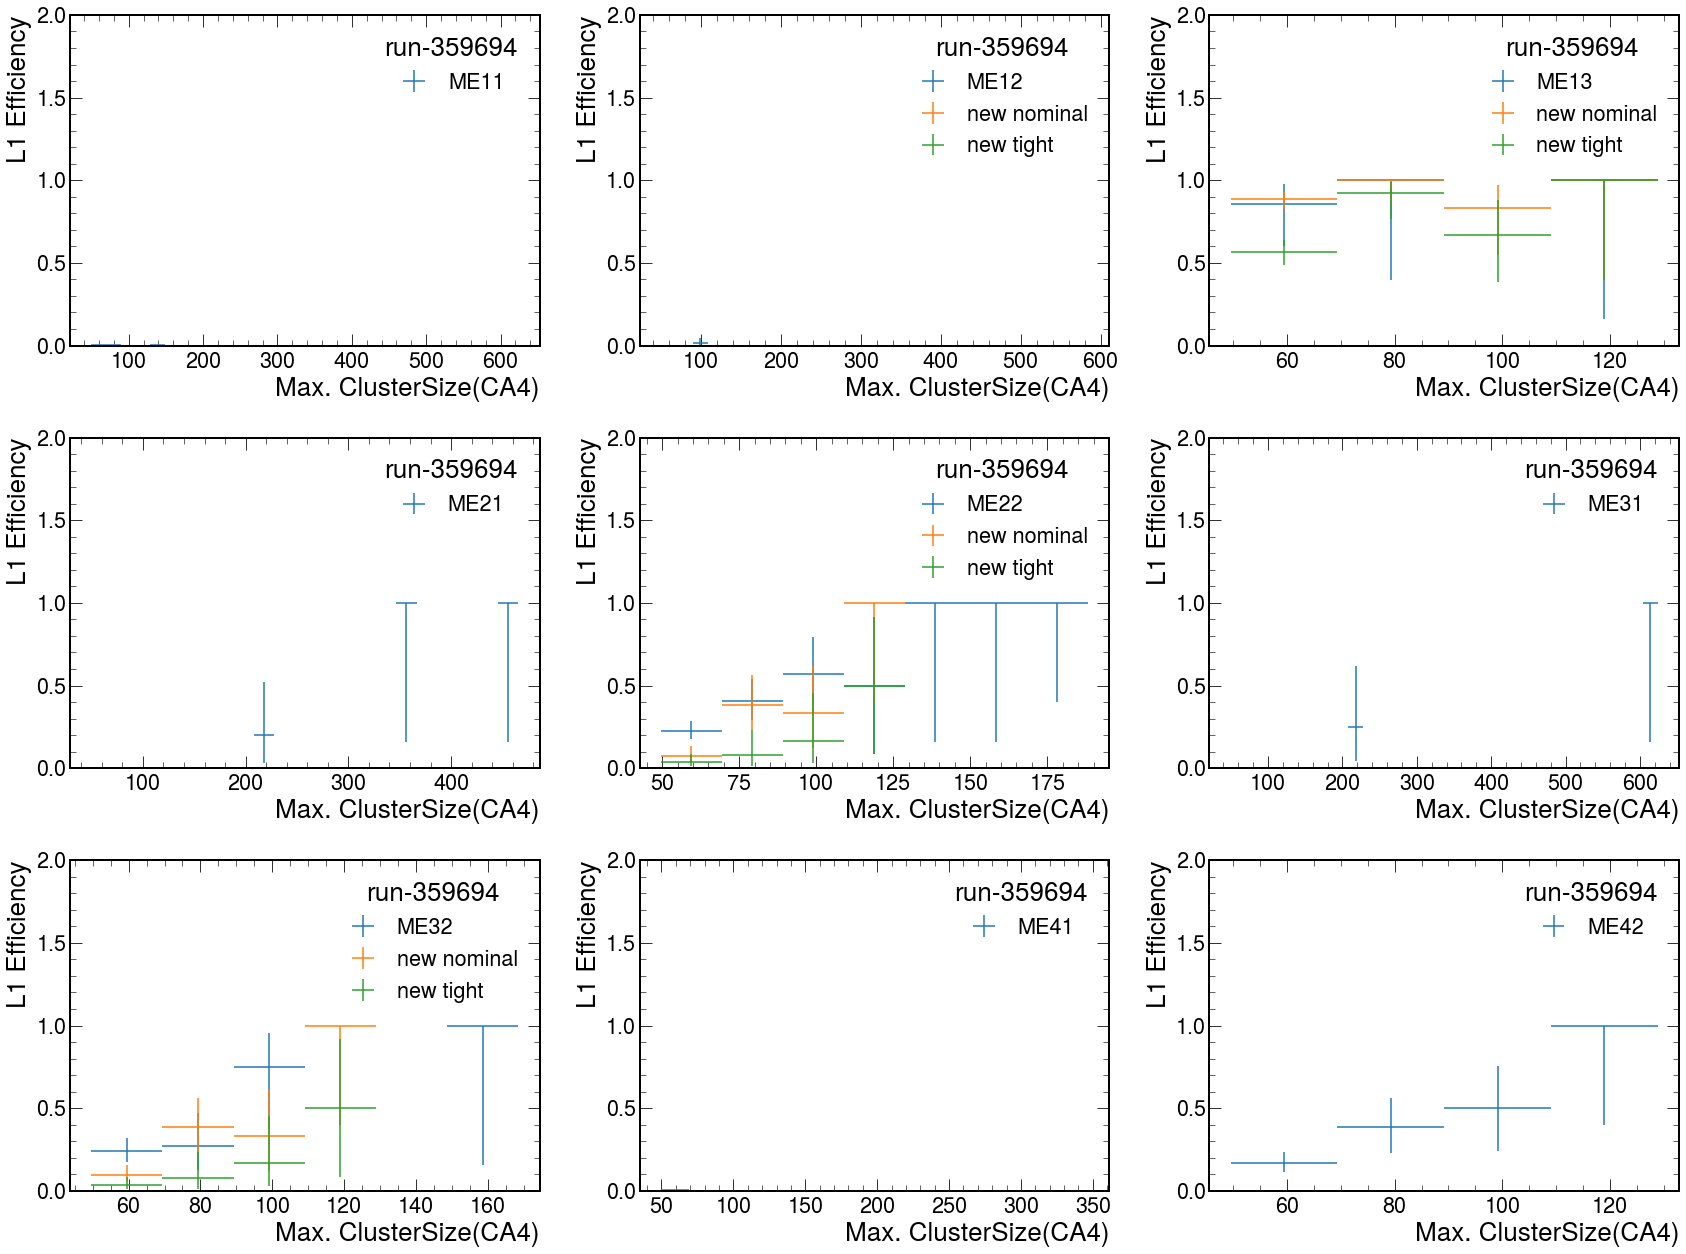

In [16]:
ME11 = (cls.R>100)&(cls.R<275) &(abs(cls.Z)>580)&(abs(cls.Z)<632) 
ME12 = (cls.R>275)&(cls.R<465) &(abs(cls.Z)>668)&(abs(cls.Z)<724)
ME13 = (cls.R>505)&(cls.R<700) &(abs(cls.Z)>668)&(abs(cls.Z)<724)

ME21 = (cls.R>139)&(cls.R<345) &(abs(cls.Z)>789)&(abs(cls.Z)<850)
ME22 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>791)&(abs(cls.Z)<850)

ME31 = (cls.R>160)&(cls.R<345) &(abs(cls.Z)>915)&(abs(cls.Z)<970)
ME32 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>911)&(abs(cls.Z)<970)

ME41 = (cls.R>178)&(cls.R<345) &(abs(cls.Z)>1002)&(abs(cls.Z)<1063)
ME42 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>1002)&(abs(cls.Z)<1063)

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(3,3, figsize=(24,18))
axs = axs.flatten()

def plotEff(numer,denom,ax):
    h= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("ClusterSize", "ClusterSize", 50, 10, 1000))        
    h.fill(sample="numer",ClusterSize=numer)
    h.fill(sample="denom",ClusterSize=denom)

    hist.plotratio(num=h.integrate("sample",'numer'),
                   denom=h.integrate("sample",'denom'),
                    xerr=True,
                   error_opts={"linestyle":'none',},
                   ax=ax,clear=False
                  )
    return ax


for i,region in enumerate([ME11,ME12,ME13,ME21,ME22,ME31,ME32,ME41,ME42]):
    sel = ak.all(region&(cls.Nstation10==1),axis=1) 
    denom = ak.fill_none(ak.max(cls[sel].Size,axis=1),-1)
    numer = ak.fill_none(denom[hmt[sel].passL1==1],-1)    
    plotEff(numer,denom,axs[i])
    
thresholds       = [140,14,28,26]
tight_thresholds = [140,18,32,34]

for i,ax_i in enumerate([1,2,4,6]):
    sel = ak.all(region&(cls.Nstation10==1),axis=1) 
    denom = ak.fill_none(ak.max(cls[sel].Size,axis=1),-1)
    numer = ak.fill_none(denom[ak.any(elctHMT[sel].WireNHits>thresholds[i],axis=1)],-1)    
    numer_tight = ak.fill_none(denom[ak.any(elctHMT[sel].WireNHits>tight_thresholds[i],axis=1)],-1)        
    plotEff(numer,denom,axs[ax_i])
    plotEff(numer_tight,denom,axs[ax_i])    
    
labels = ["ME11","ME12","ME13",'ME21','ME22','ME31','ME32',"ME41","ME42"]
runNumber = "run-359694"
# runNumber = "run 357696-357756"
for i,ax in enumerate(axs):
    ax.set_ylabel("L1 Efficiency")
    ax.set_xlabel("Max. ClusterSize(CA4)")
    if i in [1,2,4,6]:
        ax.legend(["%s"%labels[i],"new nominal","new tight"],title=runNumber)    
    else:
        ax.legend(["%s"%labels[i]],title=runNumber)            
    ax.set_ylim(0,2)
    plt.tight_layout()

# Plot from pickle

In [3]:
with open("run2022E.pickle", 'rb') as fp:
    out = pickle.load(fp)

In [10]:
labels = ["ME11","ME12","ME13",'ME21','ME22','ME31','ME32',"ME41","ME42"]

In [7]:
out

{'nClusters': <Hist (sample,nClusters) instance at 0x7f594cb66750>,
 'eta': <Hist (sample,eta) instance at 0x7f594c47a250>,
 'phi': <Hist (sample,phi) instance at 0x7f594c47af90>,
 'size': <Hist (sample,size) instance at 0x7f594c7f5150>,
 'time': <Hist (sample,time) instance at 0x7f594bb2e610>,
 'nME11_12': <Hist (sample,nME11_12) instance at 0x7f594c5bba10>,
 'x': <Hist (sample,x) instance at 0x7f594c5bbd10>,
 'y': <Hist (sample,y) instance at 0x7f594c9db050>,
 'z': <Hist (sample,z) instance at 0x7f594c9db350>,
 'Nstation10': <Hist (sample,Nstation10) instance at 0x7f594c9db690>,
 'AvgStation10': <Hist (sample,AvgStation10) instance at 0x7f594c9db9d0>,
 'timeSpread': <Hist (sample,timeSpread) instance at 0x7f594c9dbd10>,
 'ME11': <Hist (sample,ClusterSize) instance at 0x7f594ba0d0d0>,
 'ME12': <Hist (sample,ClusterSize) instance at 0x7f594ba0d5d0>,
 'ME13': <Hist (sample,ClusterSize) instance at 0x7f594ba0da10>,
 'ME21': <Hist (sample,ClusterSize) instance at 0x7f594ba0de50>,
 'ME22':

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encounter

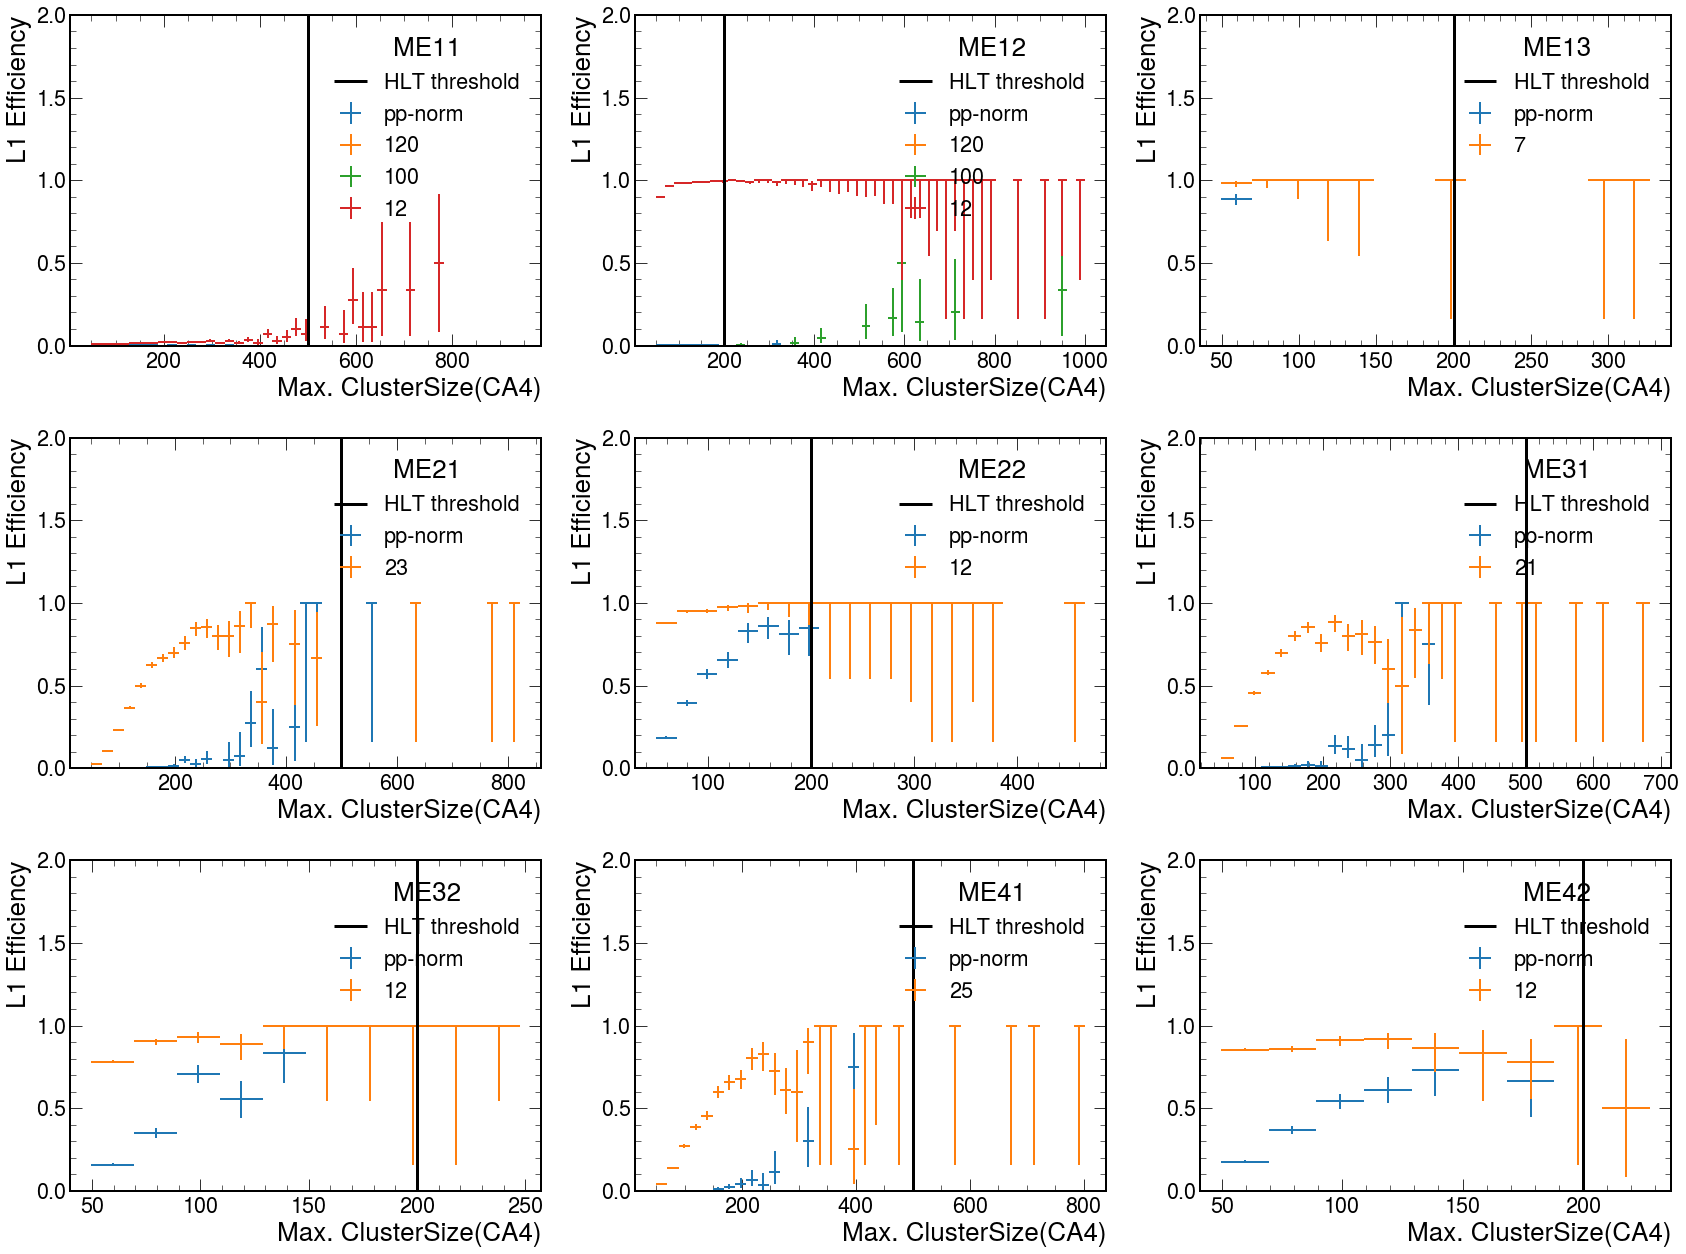

In [18]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(3,3, figsize=(24,18))
axs = axs.flatten()

for i,station in enumerate(labels):
    hlist = [(h,hname) for hname,h in out.items() if station in hname and "n" not in hname]
    for (h,hname) in hlist:
        if len(hname.split("_"))>1:
            threshold = hname.split("_")[1]
            label = threshold
        else:
            label = "pp-norm"
        
        hist.plotratio(num=h.integrate("sample",'numer'),
                       denom=h.integrate("sample",'denom'),
                        xerr=True,
                       error_opts={"linestyle":'none',"lw":2},
                       ax=axs[i],clear=False,
                      label=label)
    
runNumber = "Run2022E"    
for i,ax in enumerate(axs):
    ax.set_ylabel("L1 Efficiency")
    ax.set_xlabel("Max. ClusterSize(CA4)")
    if i in [1,2,4,6,8]:
        ax.vlines(200,0,2,color='black',label="HLT threshold",lw=3)    
    else:
        ax.vlines(500,0,2,color='black',label="HLT threshold",lw=3)    
    ax.legend(title=labels[i])
        
#     if i in [1,2,4,6]:
#         ax.legend(["%s"%labels[i],"new nominal","new tight"],title=runNumber)    
#     else:
#         ax.legend(["%s"%labels[i]],title=runNumber)            
    ax.set_ylim(0,2)
    plt.tight_layout()